Import library: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


CPU or GPU 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Set parameter :

In [ ]:
num_epochs = 5
# batch_size = 40
learning_rate = 0.001


classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

Load Cifar10 dataset: 

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


validataion data: 

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_dataset) * 0.10)
train_size = len(train_dataset) - val_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])
len(train_dataset), len(validation_dataset)

(45000, 5000)

Preparing the dataset for learning with dataloader : 

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Displaying cifar10 dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


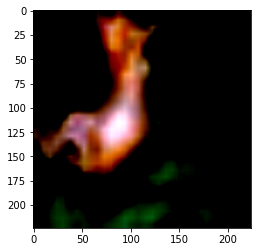

cat


In [ ]:
def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


for images, labels in train_loader:
    imshow(images[0])
    print(classes[labels[0].item()])
    break    

VGG model 

In [ ]:
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)




/ Criterion: / Optimizer:  

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

Training the model : 

In [ ]:
train_loss_list = []
valid_loss_list = []

train_acc_list = []
valid_acc_list = []


for epoch in range(num_epochs):
  train_loss = 0
  valid_loss = 0

  train_true_sum = 0
  valid_true_sum = 0

  train_count_sum = 0 
  valid_count_sum = 0 


  model.train()
  for i, (imgs , labels) in enumerate(train_loader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    labels_hat = model(imgs)
    n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()


    train_true_sum += n_corrects
    train_count_sum += len(labels)

    loss_value = criterion(labels_hat, labels)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss_value.item()


  train_loss_list.append(train_loss/len(train_loader))
  train_acc_list.append(train_true_sum/train_count_sum)

  model.eval()


  for i, (imgs , labels) in enumerate(validation_loader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    labels_hat = model(imgs)
    n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()


    valid_true_sum += n_corrects
    valid_count_sum += len(labels)

    loss_value = criterion(labels_hat, labels)


    valid_loss += loss_value.item()

  valid_loss_list.append(valid_loss/len(validation_loader))
  valid_acc_list.append(valid_true_sum/valid_count_sum)

  print("Epoch :", epoch+1)
  print("===================================================================================================")
  print("Train Loss :",train_loss/len(train_loader), " Validataion Loss : ",valid_loss/len(validation_loader))
  print("Train Accuracy :",train_true_sum/train_count_sum, " Validataion Loss : ",valid_true_sum/valid_count_sum)
  print("===================================================================================================")



print("Training Done!")

Epoch : 1
Train Loss : 0.4431417802111765  Validataion Loss :  0.3023864463161511
Train Accuracy : 0.8468666666666667  Validataion Loss :  0.8986
Epoch : 2
Train Loss : 0.22383518441028855  Validataion Loss :  0.2469720857805175
Train Accuracy : 0.9229777777777778  Validataion Loss :  0.9168
Epoch : 3
Train Loss : 0.14056759280372377  Validataion Loss :  0.20542956673047819
Train Accuracy : 0.9511111111111111  Validataion Loss :  0.9312
Epoch : 4
Train Loss : 0.09114927162345784  Validataion Loss :  0.21340857002480773
Train Accuracy : 0.9684888888888888  Validataion Loss :  0.931
Epoch : 5
Train Loss : 0.06360019200103807  Validataion Loss :  0.26669312856949057
Train Accuracy : 0.9779333333333333  Validataion Loss :  0.921
Training Done!


Loss / epoch plot : 

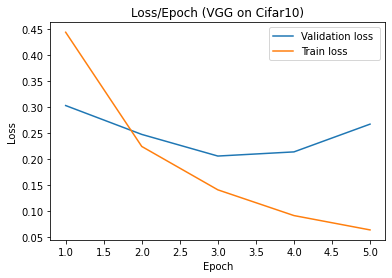

In [ ]:


epoch_ = [i+1 for i in range(epoch+1)]
plt.plot(epoch_,valid_loss_list,label = "Validation loss ")
plt.plot(epoch_,train_loss_list,label = "Train loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss/Epoch (VGG on Cifar10)")
plt.show()


Accuracy / Epoch 

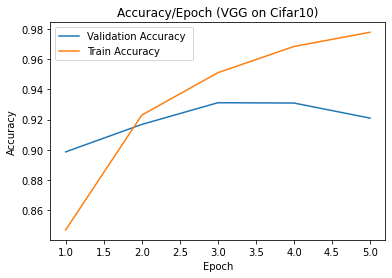

In [ ]:



plt.plot(epoch_,valid_acc_list,label = "Validation Accuracy ")
plt.plot(epoch_,train_acc_list,label = "Train Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy/Epoch (VGG on Cifar10)")
plt.show()


Test the Model: 

In [ ]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')



Overall accuracy 92.06%


Displaying image: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


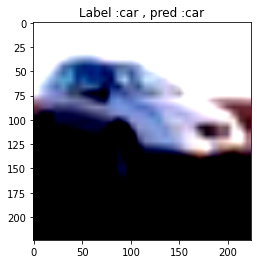

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


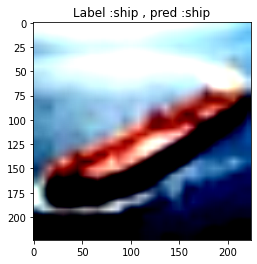

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


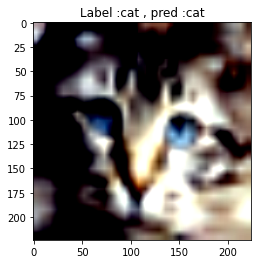

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


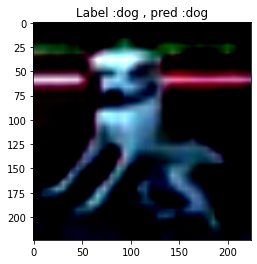

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


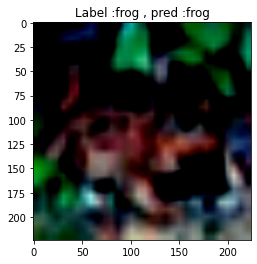

In [ ]:
import numpy as np 
def imshow1(img,label,pred):    # unnormalize

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Label :{} , pred :{}".format(label,pred))
    plt.show()

classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

counter = 0 


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.4914, 1/0.4822, 1/0.4465 ]),
                                transforms.Normalize(mean = [ -0.2023, -0.1994, -0.2010 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

model.eval()

for images, labels in test_loader:
  test_images_set = images.to(device)
  y_predicted = model(test_images_set)
  labels_predicted = y_predicted.argmax(axis = 1)

  if counter <5 :
    inv_tensor = invTrans(images[0])

    imshow1(inv_tensor,classes[labels[0]],classes[labels_predicted[0]])
  
  else :
    break 
  counter +=1    

Save Model : 

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/model.pt')


Load Model : 

In [ ]:
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/model.pt'))
model.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

FGSM Attack : 

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Global seed set to 42


Using device cuda:0


In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model_ = "/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/model.pt"
use_cuda=True


# Initialize the network
pretrained_model = models.vgg16(pretrained = True)
input_lastLayer = pretrained_model.classifier[6].in_features
pretrained_model.classifier[6] = nn.Linear(input_lastLayer,10)
pretrained_model = pretrained_model.to(device)

# Load the pretrained model
pretrained_model.load_state_dict(torch.load(pretrained_model_, map_location='cpu'))


# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [ ]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:


_ = eval_model(test_loader)

Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 7.94%
Top-5 error: 0.19%


In [ ]:
NORM_MEAN = np.array([0.4914, 0.4822, 0.4465])
NORM_STD = np.array([0.2023, 0.1994, 0.2010])



In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

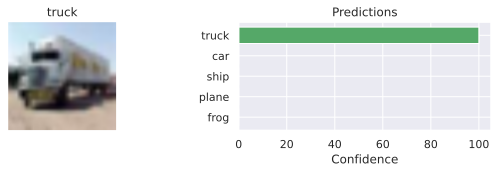

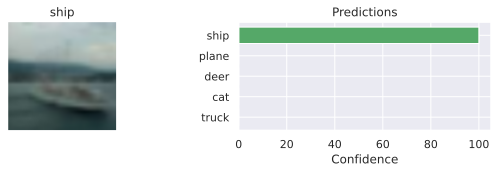

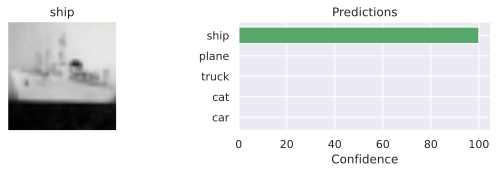

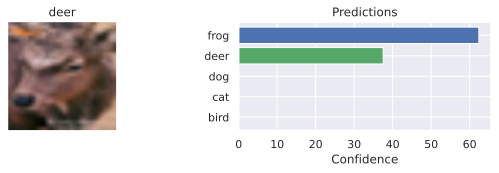

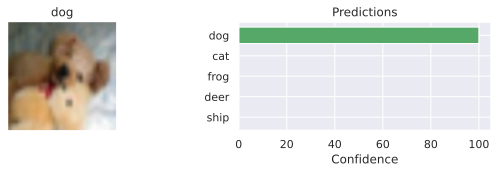

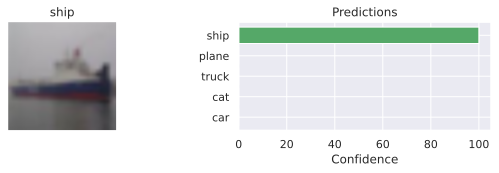

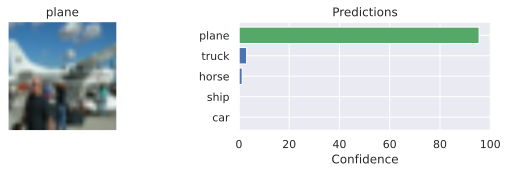

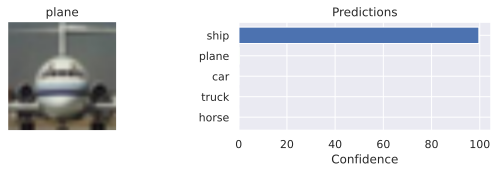

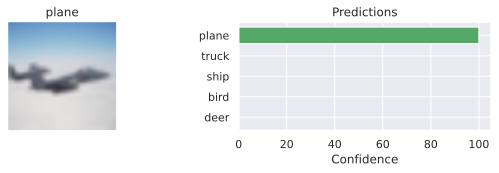

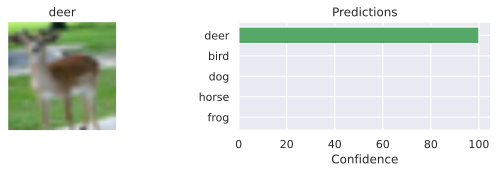

In [ ]:
exmp_batch, label_batch = next(iter(test_loader))
label_names = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(10):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

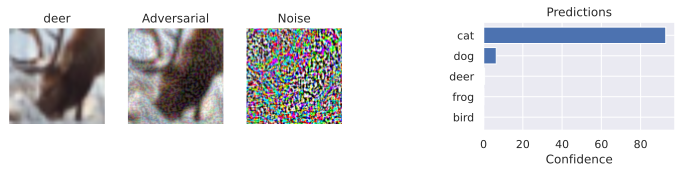

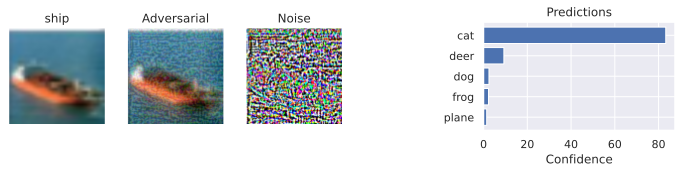

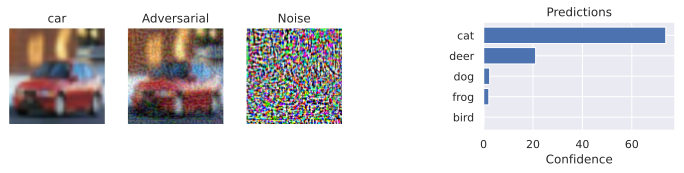

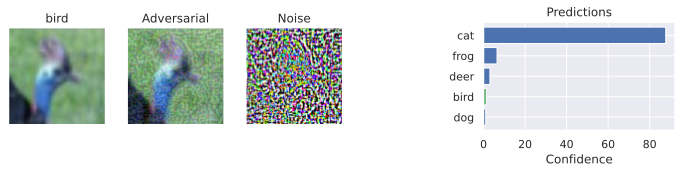

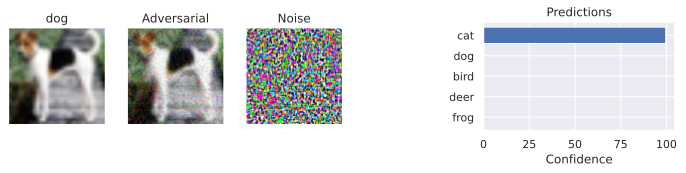

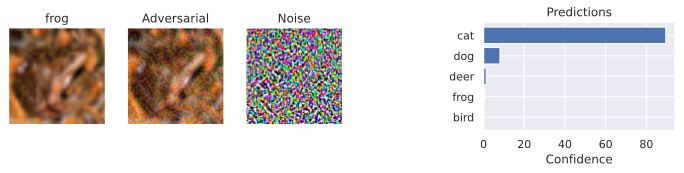

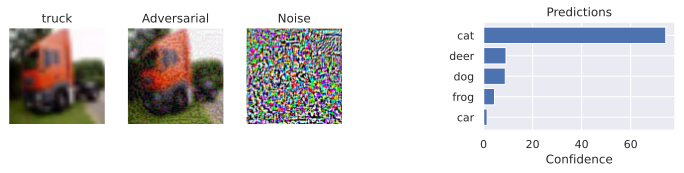

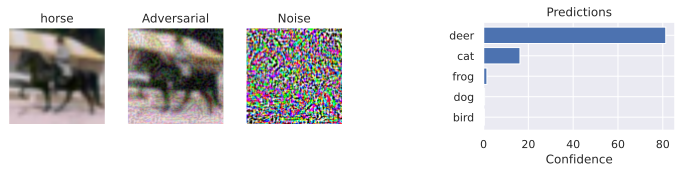

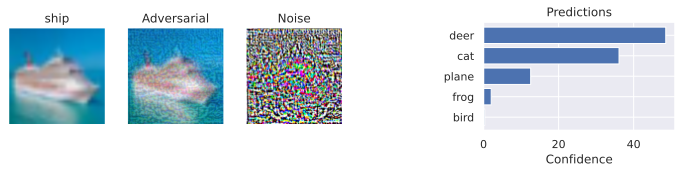

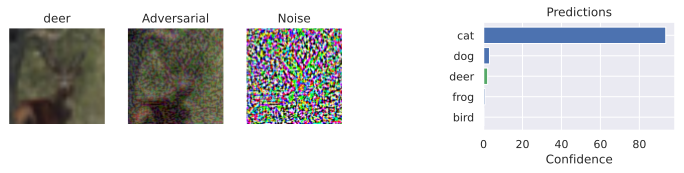

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.5)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(10):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Accuracy FGSM : 

In [ ]:
# exmp_batch, label_batch = next(iter(test_loader))
accuracy = []
epsilon = [0,0.1,0.2,0.3,0.4,0.5]

for eps in epsilon:
  number_corrects = 0
  number_samples = 0
  for exmp_batch, label_batch in test_loader: 
    adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=eps)
    with torch.no_grad():
      adv_preds = pretrained_model(adv_imgs.to(device))
      labels_predicted = adv_preds.argmax(axis = 1)
      label_batch  = label_batch.to(device)
      number_corrects += (labels_predicted==label_batch).sum().item()
      number_samples += label_batch.size(0)
  accuracy.append(number_corrects/number_samples)
      
print(accuracy)


[0.9206, 0.1164, 0.1368, 0.1253, 0.1107, 0.1041]


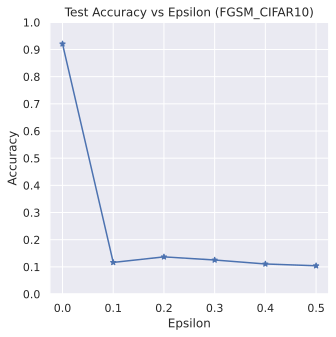

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilon, accuracy, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title("Test Accuracy vs Epsilon (FGSM_CIFAR10)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()